In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io
import os

In [2]:
## Image Dataloader
class SurgicalToolDataset(Dataset):
    """
        This class provides the implementation for accessing the surgical tool dataset.
    """
    def __init__(self,
                 dataset_dir,
                 split,
                 transform
                ):
        """
            dataset_dir: the path to the dataset folder
            split: either "train" or "test"
            transform: torchvison transformation
        """
        assert split == "train" or split == "test", "split can only be train or test."
        self.split = split
        self.dataset_dir = dataset_dir
        self.transform = transform

        split_file = os.path.join(self.dataset_dir, 'Surgical-Dataset/Test-Train Groups')
        if split == "train":
            split_file += "/train-obj_detector.txt"
        elif split == "test":
            split_file += "/test-obj_detector.txt"
        
        
        with open(split_file) as file:
            # we get the list of the directory of images for this split
            self.lines = file.readlines()
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        """
            Return:
                img: torch tensor type, with shape of C x H x W
                target: dictionary with keys "boxes" and "labels"
        """
        data_name = self.lines[idx].split("/")[-1]
        data_name = data_name.split(".")[0]
        image_dir = os.path.join(self.dataset_dir, "Surgical-Dataset/Images/All/images/" + data_name + ".jpg")
        target_dir = os.path.join(self.dataset_dir, "Surgical-Dataset/Labels/label object names/" + data_name + ".txt")
        
        img = io.imread(image_dir)
        orig_size = img.shape
        img = self.transform(img)
        size = img.shape[1:]
        
        target = {"boxes": [],
                  "labels": [],
                  "orig_size": torch.tensor(orig_size),
                  "size": torch.tensor(size),
                 }
        # construct the target from target file:
        with open(target_dir) as file:
            objects = file.readlines()
            
        for obj in objects:
            features = obj.split()
            label = int(features[0])
            # cxcyhw:
            box = [float(features[1]),
                   float(features[2]),
                   float(features[3]),
                   float(features[4])]
            target['boxes'].append(box)
            target['labels'].append(label)
        
        target['boxes'] = torch.tensor(target['boxes'])
        target['labels'] = torch.tensor(target['labels'])

        return img, target

# Test our dataset:

In [3]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

In [4]:
T = transforms.Compose([
        transforms.ToTensor(),
])

In [5]:
train_dataset = SurgicalToolDataset("./", split="train", transform=T)

In [6]:
img, target = train_dataset[0]

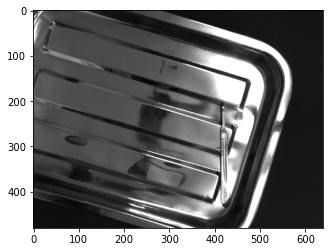

In [7]:
plt.imshow(img[0],cmap="gray")

In [8]:
def show_img(img, target):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(img[0], cmap="gray")

    boxes = target["boxes"]
    labels = target["labels"]
    actual_size = img.shape  # C x H x W
    actual_size = actual_size[1:]

    for i in range(len(labels)):
        box = boxes[i]

        b0 = box[0] * actual_size[1]
        b1 = box[1] * actual_size[0]
        b2 = box[2] * actual_size[1]
        b3 = box[3] * actual_size[0]

        label = labels[i]
        # Create a Rectangle patch
        rect = patches.Rectangle((b0 - b2 / 2, b1 - b3 / 2), b2, b3, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

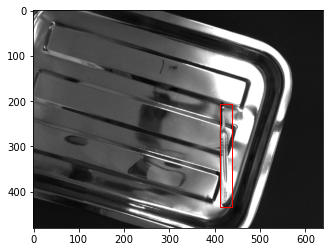

In [9]:
show_img(img, target)

# Test with dataloader:

In [10]:
def collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    targets = list(targets)
    return imgs, targets

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_fn)

In [11]:
for imgs, targets in train_dataloader:
    print(imgs.shape) # batch x channel x H x W
    print(targets) # list of dics
    break

torch.Size([5, 1, 480, 640])
[{'boxes': [tensor([0.6000, 0.4861, 0.3578, 0.0806])], 'labels': [tensor(0)], 'orig_size': tensor([480, 640]), 'size': torch.Size([480, 640])}, {'boxes': [tensor([0.5891, 0.3625, 0.2531, 0.3583])], 'labels': [tensor(0)], 'orig_size': tensor([480, 640]), 'size': torch.Size([480, 640])}, {'boxes': [tensor([0.7055, 0.1972, 0.3500, 0.1417]), tensor([0.8098, 0.3972, 0.1727, 0.5472])], 'labels': [tensor(0), tensor(3)], 'orig_size': tensor([480, 640]), 'size': torch.Size([480, 640])}, {'boxes': [tensor([0.4852, 0.5535, 0.2812, 0.3514])], 'labels': [tensor(1)], 'orig_size': tensor([480, 640]), 'size': torch.Size([480, 640])}, {'boxes': [tensor([0.4742, 0.5257, 0.3781, 0.5736])], 'labels': [tensor(1)], 'orig_size': tensor([480, 640]), 'size': torch.Size([480, 640])}]
